# Analyze NetBERT improvements over BERT predictions
The goal is to extract the right predictions of BERT-base on the dev set, and pass only these subset to NetBERT to see if it performs at least as well as BERT-base. Then, extract the wrong predictions of BERT-base and see where NetBERT improves, which specific cases, which classes in particluar, which type of sentences (badly written, not clear?)

In [49]:
import os
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2, style="whitegrid", font="sans-serif")

## 1. Prepare evaluation datasets
This code convert 'preds_right.csv' (right preds made by BERT) and 'preds_wrong.csv (wrong preds made by BERT) into two csv files in the form needed to perform evaluation with NetBERT.

In [77]:
def create_eval_dataset(infile, outfile, class_mappings):
    """
    """
    # Load right predictions from BERT-base
    df = pd.read_csv(os.path.join(dirpath, infile), index_col=0)

    # Create columns with classes.
    df['Class'] = df.apply(lambda row: class_mappings[str(row.Class_id)], axis=1)
    df['Prediction'] = df.apply(lambda row: class_mappings[str(row.Prediction_id)], axis=1)

    # Drop useless columns.
    to_drop = ['Class_id', 'Prediction_id', 'Prediction']
    df.drop(to_drop, axis=1, inplace=True)
    
    # Save dataset for evaluation with NetBERT.
    df.to_csv(os.path.join(dirpath, outfile))
    return df

### 1.1. BERT predictions

In [78]:
# Load class-class_id mapping.
dirpath = './output/bert_base_cased/'
with open(os.path.join(dirpath, 'map_classes.json')) as f:
    class_mappings = json.load(f)

# Create eval dataset from BERT-base right predictions.
df_bert_right = create_eval_dataset(infile='preds_right.csv', outfile='eval_right_preds.csv', class_mappings=class_mappings)

# Create eval dataset from BERT-base wrong predictions.
df_bert_wrong = create_eval_dataset(infile='preds_wrong.csv', outfile='eval_wrong_preds.csv', class_mappings=class_mappings)

# Create full test dataset.
df_bert = pd.concat([df_bert_right,df_bert_wrong], ignore_index=True)
df_bert.to_csv(os.path.join(dirpath, 'eval_preds.csv'))

### 1.2. NetBERT predictions

In [10]:
# Load class-class_id mapping.
dirpath = './output/netbert-final/'
with open(os.path.join(dirpath, 'map_classes.json')) as f:
    class_mappings = json.load(f)

# Create eval dataset from NetBERT right predictions.
df_netbert_right = create_eval_dataset(infile='preds_right.csv', outfile='eval_right_preds.csv', class_mappings=class_mappings)

# Create eval dataset from NetBERT wrong predictions.
df_netbert_wrong = create_eval_dataset(infile='preds_wrong.csv', outfile='eval_wrong_preds.csv', class_mappings=class_mappings)

# Create full test dataset.
df_netbert = pd.concat([df_netbert_right,df_netbert_wrong], ignore_index=True)
df_netbert.to_csv(os.path.join(dirpath, 'eval_preds.csv'))

## 2. Analysis

In [93]:
def load_dataset(dirpath, filepath, class_mappings):
    """
    """
    # Load right predictions from BERT-base
    df = pd.read_csv(os.path.join(dirpath, filepath), index_col=0)

    # Create columns with classes.
    df['Class'] = df.apply(lambda row: class_mappings[str(row.Class_id)], axis=1)
    df['Prediction'] = df.apply(lambda row: class_mappings[str(row.Prediction_id)], axis=1)

    # Drop useless columns.
    to_drop = ['Class_id', 'Prediction_id']
    df.drop(to_drop, axis=1, inplace=True)
    return df


def load_results(dirpath, filepath):
    """
    """
    with open(os.path.join(dirpath, filepath)) as f:
        result = json.load(f)
    return result
    

def plot_confusion_matrix(cm, classes, fig_name):
    """
    This function prints and plots the confusion matrix.
    """
    df_cm = pd.DataFrame(np.array(cm), index=classes, columns=classes)
    
    plt.figure(figsize = (15,10))
    ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 15}, cmap='coolwarm')
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, horizontalalignment='right', rotation=45) 
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    
    plt.ylabel('True labels', fontsize=28)
    plt.xlabel('Predicted labels', fontsize=28)
    plt.tight_layout()
    
    output = "./figures/" + fig_name + ".pdf"
    plt.savefig(output, bbox_inches='tight')
    plt.show()
    return


def compare_accuracy(bert_cm, netbert_cm, classes):
    """
    """
    df_cm1 = pd.DataFrame(np.array(bert_cm), index=classes, columns=classes)
    df_cm2 = pd.DataFrame(np.array(netbert_cm), index=classes, columns=classes)
    
    fig = plt.figure(figsize=(25,10))
    
    # First accuracy matrix.
    ax1 = fig.add_subplot(1, 2, 1)
    sns.heatmap(df_cm1, annot=True, annot_kws={"size": 15}, cmap='coolwarm')
    ax1.set_title('BERT Accuracy', fontsize=18)
    ax1.set_xlabel('True labels', fontsize=28)
    ax1.set_ylabel('Predicted labels', fontsize=28)
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=18, horizontalalignment='right', rotation=45) 
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=18)
    #extent1 = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig('./figures/bert_confmatrix.pdf', bbox_inches=extent1.expanded(2.5, 2.0))
    
    # Second accuracy matrix.
    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(df_cm2, annot=True, annot_kws={"size": 15}, cmap='coolwarm')
    ax2.set_title('NetBERT Accuracy', fontsize=18)
    ax2.set_xlabel('True labels', fontsize=28)
    ax2.set_ylabel('Predicted labels', fontsize=28)
    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=18, horizontalalignment='right', rotation=45) 
    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)
    #extent2 = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig('./figures/netbert_confmatrix.pdf', bbox_inches=extent2.expanded(2.5, 2.0))
    
    # Show figure.
    plt.tight_layout()
    plt.show()
    return
    

def plot_repartition(df, model_name, palette):
    """
    """
    # Get the counts of each document type.
    count = df['Class'].value_counts()
    count_classes = count.index.tolist()
    count_values = count.values.tolist()
    
    # Create barplot.
    fig = plt.figure(figsize=(25,8))
    ax1 = fig.add_subplot(1, 2, 1)

    sns.barplot(count_classes, count_values, palette=palette)
    
    ax1.set_title(model_name + " wrong predictions", fontsize=24)
    ax1.set_xlabel('Number of queries', fontsize=18)
    ax1.set_ylabel('Document Type ', fontsize=18)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=35, horizontalalignment='right', fontsize=11)

    rects = ax1.patches
    for rect, label in zip(rects, count_values):
        ax1.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.5, label, ha='center', va='bottom', fontsize=12)

    # Create pie chart.
    ax2 = fig.add_subplot(1, 2, 2)
    colors = [palette[clss] for clss in count_classes]
    df.Class.value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=270, fontsize=17, labels=None, colors=colors)
    ax2.set_ylabel('')
    ax2.legend(loc=(0.8,0.8), labels=count_classes)
    extent2 = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('./figures/' + model_name +'_piechart_wrong_preds.pdf', bbox_inches=extent2.expanded(2.5, 1.5))
    
    
    # Show the plot.
    plt.show()
    return


def plot_accuracy_improvement(bert_cm, netbert_cm, classes):
    """
    """
    df = pd.DataFrame(columns=['Accuracy', 'Class', 'Model'])

    # Create BERT dataframe.
    bert_df = df.copy(deep=True)
    bert_df['Accuracy'] = np.diag(bert_cm)
    bert_df['Class'] = classes
    bert_df['Model'] = 'BERT'
    bert_df = bert_df.append({'Accuracy':bert_result['Accuracy'],'Class':r'$\bf{Global}$','Model':'BERT'}, ignore_index=True)

    # Create NetBERT dataframe.
    netbert_df = df.copy(deep=True)
    netbert_df['Accuracy'] = np.diag(netbert_cm)
    netbert_df['Class'] = classes
    netbert_df['Model'] = 'NetBERT'
    bert_df = bert_df.append({'Accuracy':netbert_result['Accuracy'],'Class':r'$\bf{Global}$','Model':'NetBERT'}, ignore_index=True)

    # Concat the two dataframes.
    df = pd.concat([bert_df, netbert_df], axis=0, sort=False)

    # Plot barplot.
    plt.figure(figsize = (20,10))

    ax = sns.barplot(x="Class", y="Accuracy", hue="Model", data=df, palette="Paired")
    #plt.title('Accuracy comparison', fontsize=18)
    plt.ylabel('Accuracy', fontsize=28)
    plt.xlabel('Document type', fontsize=28)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, horizontalalignment='center', rotation=0) 
    
    # Annotate bars with improvements.
    rects = ax.patches[-len(bert_df.Class.unique()):]
    labels = np.diag(netbert_cm) - np.diag(bert_cm)
    labels = np.append(labels, netbert_result['Accuracy']-bert_result['Accuracy'])
    labels = labels*100
    labels = ["+{:0.1f}%".format(label) if np.sign(label) >=0 else "- {:0.1f}%".format(abs(label)) for label in labels]
    for rect, label in zip(rects, labels):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.005, label, ha='center', va='bottom', fontsize=15)
        
    # Sized of legend.
    ax.legend(loc=(0.,0.91), fontsize='16')
    #plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text

    # Save plot.
    plt.savefig("./figures/accuracy_comparison.pdf", bbox_inches='tight')
    
    # SHow plot.
    plt.tight_layout()
    plt.show()
    return


def piechart_bad_preds(df, palette):
    """
    """
    # Get misclassified classes.
    classes = df.Class.unique().tolist()
    
    # Init figure.
    nb_cols = 3
    nb_rows = int(np.ceil(len(classes)/nb_cols))
    fig = plt.figure(figsize=(25,8))
    
    # Draw pie-chart for each misclassified class.
    for i, clss in enumerate(classes):
        count = df[df['Class']==clss].Prediction.value_counts()
        count_classes = count.index.tolist()
        count_values = count.values.tolist()
        
        ax = fig.add_subplot(nb_rows, nb_cols, i+1)
        colors = [palette[c] for c in count_classes]
        count.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=270, fontsize=10, labels=None, colors=colors)
        
        ax.set_title("'{}'".format(clss), fontsize=14)
        ax.set_ylabel('')
        ax.legend(loc=(1,0.4), labels=count_classes)
        
    plt.show()
    return

### 2.1. Comparison between BERT and NetBERT predictions

- Goal: Compare the accuracy of both models for each class individually.
- Analysis:
    * Overall, NetBERT performs much better than BERT, with an improvement of ~3.5% on the predictions.
    * By considering classes individually, one can notice that NetBERT outperforms BERT for most of the classes (except for 'Release Notes' where accuracy is similar, and 'Data Sheets' where NetBERT loses 1% accuracy over BERT). The most surprising result is an improvement of ~9% for the 'Data Sheets' class.
    * Looking at the wrong predictions of both models, one can see that the most misclassified class with BERT is 'Install & Upgrade guides', while NetBERT seems to have more difficulty with the 'Data Sheets' class.

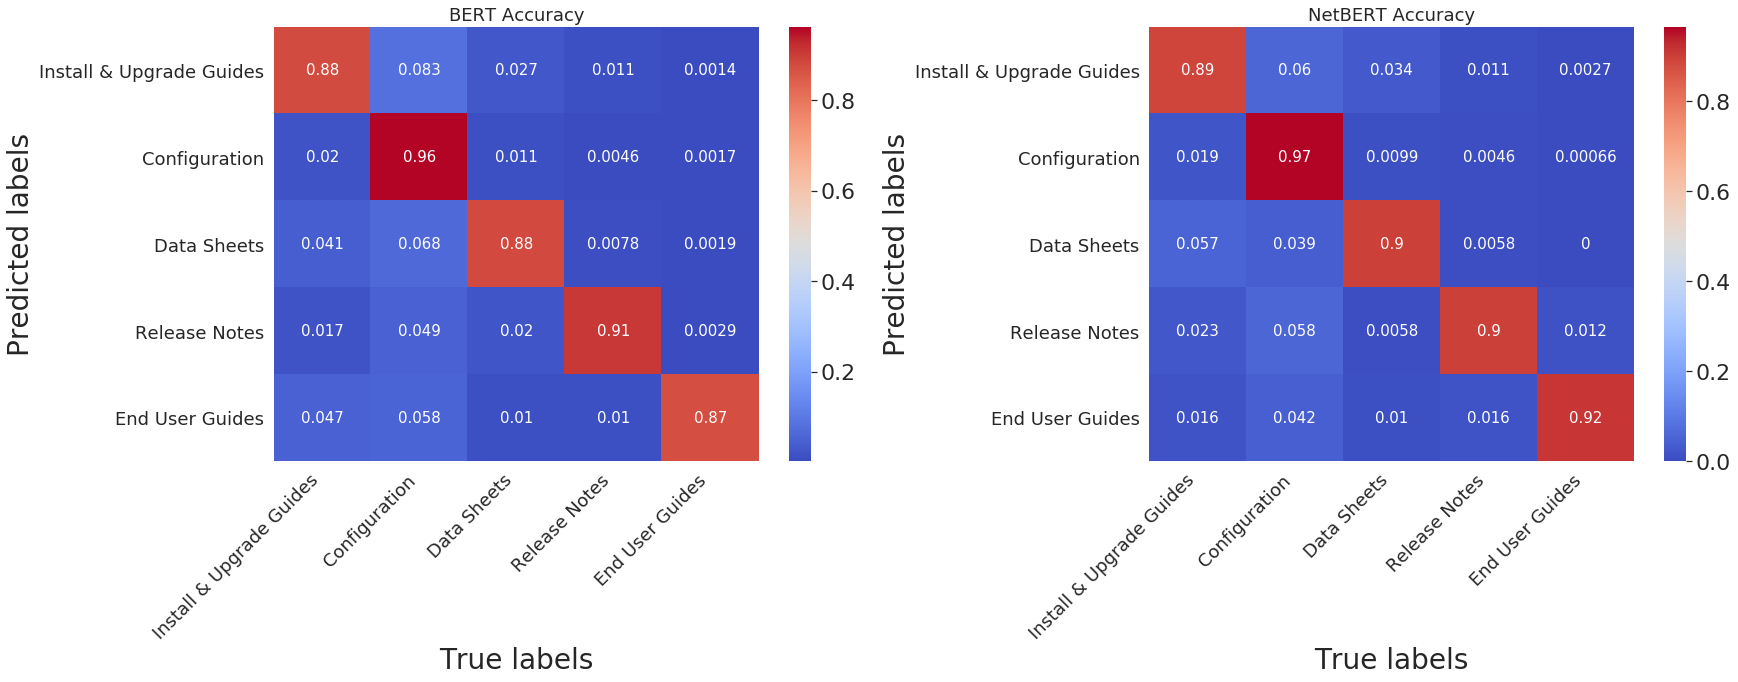

In [75]:
# Compare accuracy.
bert_result = load_results(dirpath='./output/bert_base_cased/', filepath='test_scores.json')
netbert_result = load_results(dirpath='./output/netbert-final/', filepath='test_scores.json')
compare_accuracy(bert_cm=bert_result['conf_matrix'], netbert_cm=netbert_result['conf_matrix'], classes=list(class_mappings.values()))
#plot_confusion_matrix(bert_result['conf_matrix'], list(class_mappings.values()), "bert_confusion_matrix")
#plot_confusion_matrix(netbert_result['conf_matrix'], list(class_mappings.values()), "netbert_confusion_matrix")

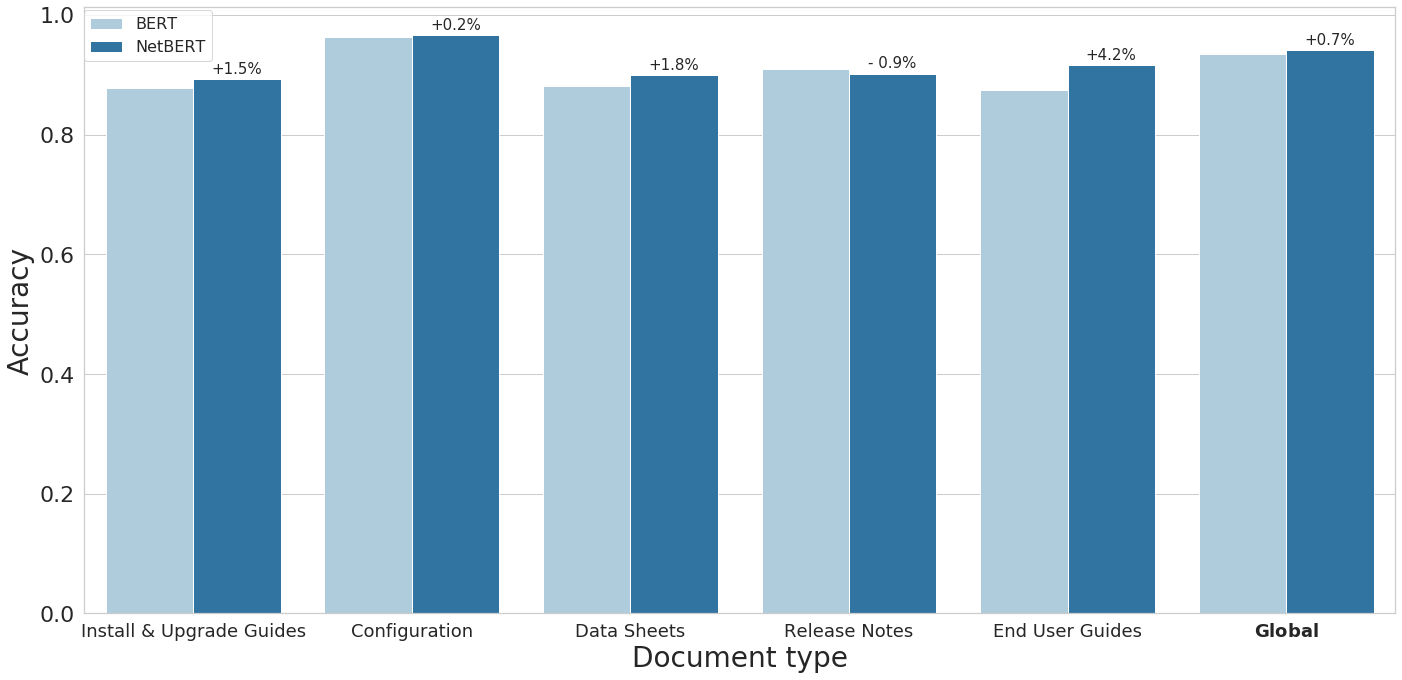

In [73]:
# Visualize NetBERT improvements in accuracy for each class.
plot_accuracy_improvement(bert_cm=bert_result['conf_matrix'], netbert_cm=netbert_result['conf_matrix'], classes=list(class_mappings.values()))

In [132]:
# Get an insight of the queries that NetBERT got right while BERT misclassified them.
def analysis(df_netbert_right, df_bert_wrong, doctype):
    """
    Get queries missclassified by bert but well predicted by netbert.
    """
    netbert_right = df_netbert_right[df_netbert_right.Class == doctype].Sentence.values.tolist()
    bert_wrong = df_bert_wrong[df_bert_wrong.Class == doctype].Sentence.values.tolist()
    results = list(set(netbert_right).intersection(bert_wrong))
    return results




doctypes = ['Install & Upgrade Guides',
  'Configuration (Guides, Examples & TechNotes)',
  'Data Sheets',
  'End User Guides']

for t in doctypes:
    print("\nDocument type: {}". format(t))
    print("----------------------------------------")
    results = analysis(df_netbert_right, df_bert_wrong, t)
    for res in results:
        print("  {}".format(res))



Document type: Install & Upgrade Guides
----------------------------------------
  800 external antenna
  Cisco AP 4800 AP
  APIC NXOS 4.1
  800  Bracket
  bits framer maxim requirement asr920
  Catalyst 3750-X Series Switches: Preface: Related Publications
  Cisco Nexus 7000 Series NX-OS reload supervisor
  ASR920 USB software
  Cisco Nexus 77
  catalyst 9300 virtual stackwise
  Cisco cBR-8 supervisor
  What is the Cisco Security Manager?
  asr 903 minor Alarm Conditions
  poe mode a mode b
  3750-X USB mini-Type B
  ucs c240 tpm
  Firepower 4100 Series FTD Available Updates
  sizing guide Cisco Firepower Management Center (Hardware) Appliances
  interface name   rack shelf card slot
  ucs fabric interconnect 6248
  Hardware Installation Guide for Cisco NCS 5500 Series Modular Routers
  Catalyst 2960-X 48 GigE PoE 7400&#44; 2 x 10G SFP &#44; LAN Base
  c9300 48p poe
  configuration Cisco Catalyst 3650 Series Switches
  Supervisor 2 Module
  800 Series Industrial Integrated Services R

In [135]:
# Get an insight of what type of queries are 'End User Guides' (decline of NetBERT compared to BERT).
def analysis(df_netbert_wrong, df_bert_wrong, doctype):
    """
    Get queries missclassified by bert but well predicted by netbert.
    """
    netbert_wrong = df_netbert_wrong[df_netbert_wrong.Class == doctype].Sentence.values.tolist()
    bert_right = df_bert_right[df_bert_right.Class == doctype].Sentence.values.tolist()
    results = list(set(netbert_wrong).intersection(bert_right))
    return results

t = 'Release Notes'
print("\nDocument type: {}". format(t))
print("----------------------------------------")
results = analysis(df_netbert_wrong, df_bert_right, t)
for res in results:
    print("  {}".format(res))



Document type: Release Notes
----------------------------------------
  nexus 7000 fabric power-dn
  What is the License model for the Catalyst 9300 Series Switches ?
  How do I troubleshoot the Catalyst 9500?
  nexus Routing Mode
  nxos nexus 9000 software
  Bios software nexus 5000
  Cisco Unified Threat Defense
  nexus 7010 show tech
  nexus 7000 data
  Can i know Cat 9500
  KERN-2-SYSTEM_MSG after NXOS upgrade on 3172T
  Provider Edge Router


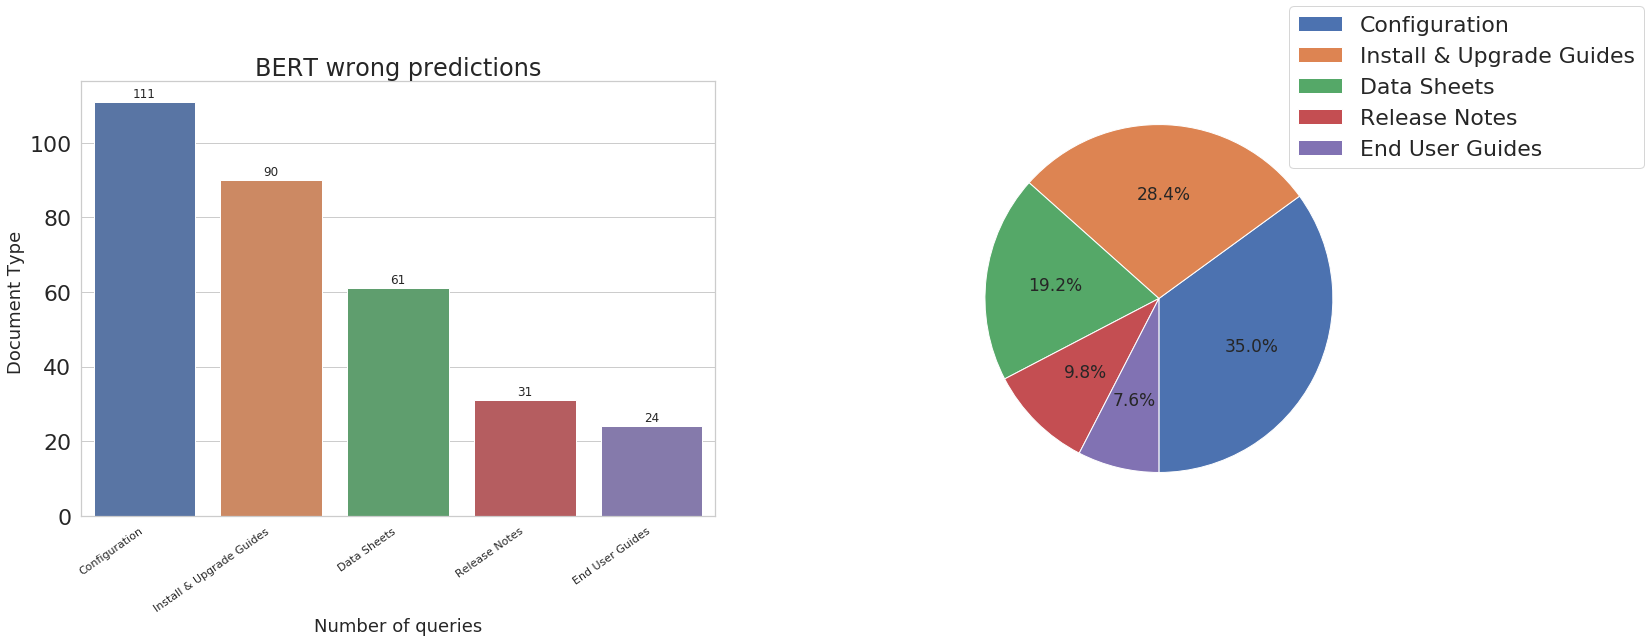

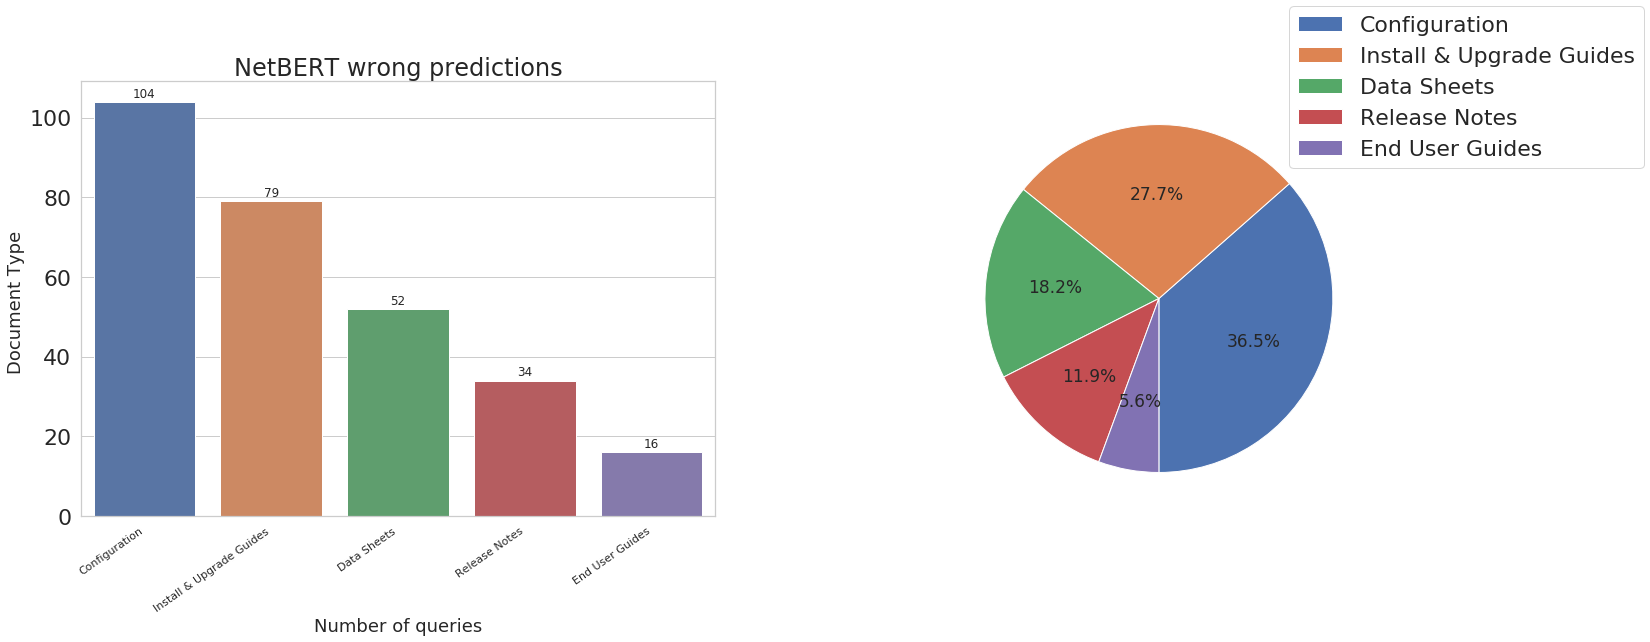

In [94]:
# Compare wrong predictions.
palette = dict(zip(df_bert_wrong['Class'].value_counts().index.tolist(), sns.color_palette()))
plot_repartition(df_bert_wrong, "BERT", palette)
plot_repartition(df_netbert_wrong, "NetBERT", palette)

### 2.2. Is NetBERT at least as good as BERT ?

- Goal: 
    * Consider only the queries that BERT correclty classified, and run NetBERT on it. The purpose is to check if NetBERT also classifies correctly these queries.
    * This is to be expected, NetBERT should normally classifies correctly the queries that BERT had right, but in addition improves those that BERT had wrong.
- Analysis:
    * Overall, NetBERT predicts correclty ~0.96% of the predictions that BERT got right, meaning that NetBERT seems approximately as good as original BERT.
    * While original BERT seems to have difficulty predicting the 'Install & Upgrade Guides" class, NetBERT seems to solve this defect as in the ~0.04% that it got wrong, it is mainly the "Data Sheets" class that predicted badly.
    * When looking at the misclassified queries for the 'Data Sheets' class, one can notice that NetBERT mainly classifies these queries as 'Install & Upgrade guides'. In a general way, the majority of the misclassified queries for all classes are predicted as 'Install & Upgrade guides'.

Accuracy: 0.982


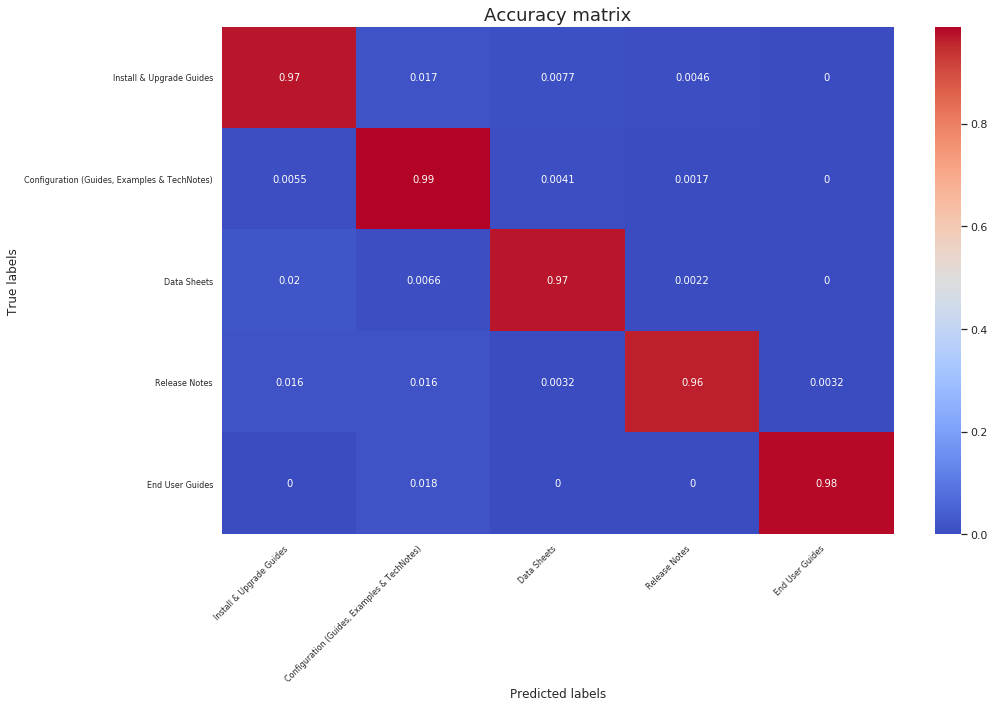

In [24]:
# Load scores.
result = load_results(dirpath=dirpath, filepath='scores_bert_right_preds.json')
print("Accuracy: {:.3f}".format(result['Accuracy']))

# Plot confusion matrix.
plot_confusion_matrix(result['conf_matrix'], list(class_mappings.values()))

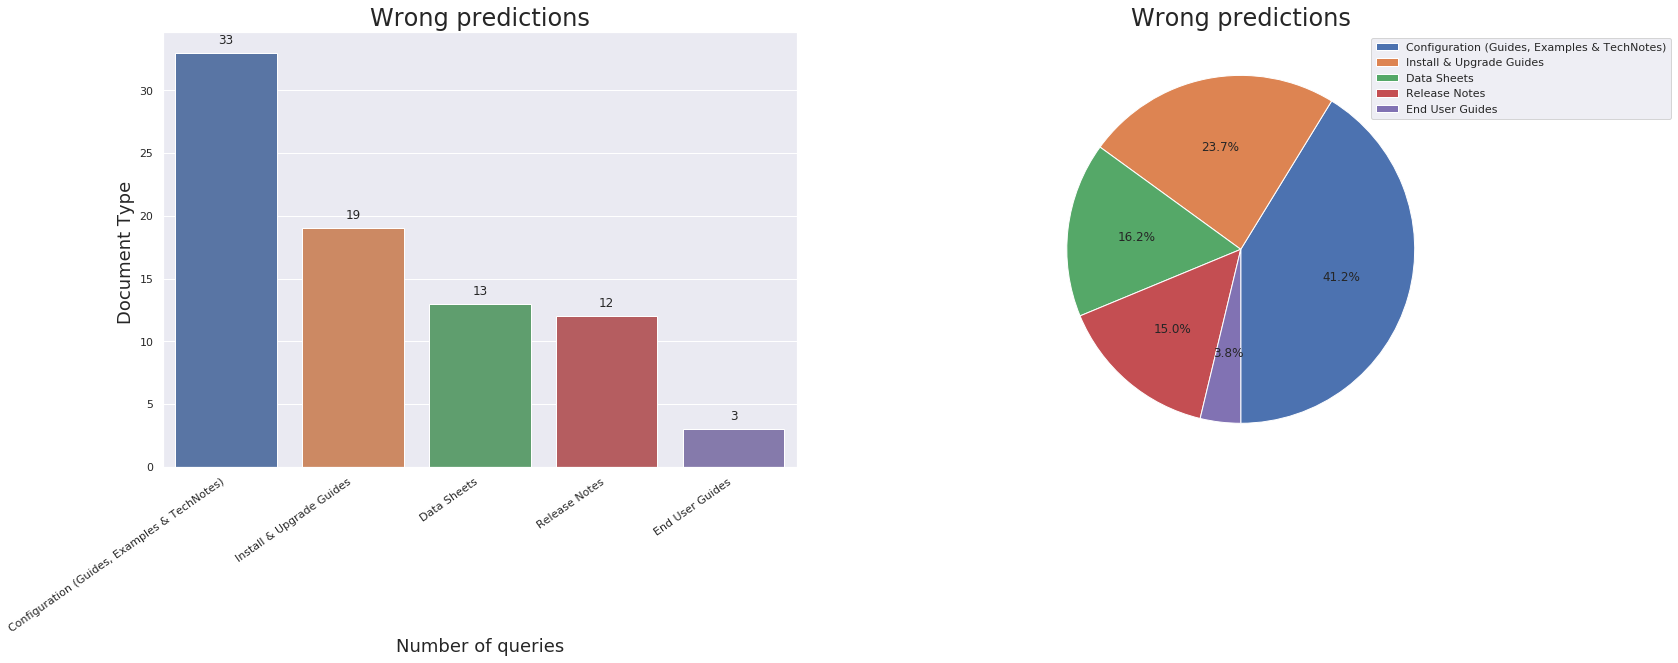

In [13]:
# Load dataset where NetBERT misclassified queries that BERT had correclty classified.
df_bert_right_netbert_wrong = load_dataset(dirpath, 'bert_right_netbert_wrong.csv', class_mappings)
palette = dict(zip(df_bert_right_netbert_wrong['Class'].value_counts().index.tolist(), sns.color_palette()))
plot_repartition(df_bert_right_netbert_wrong, "Wrong predictions", palette)

In [11]:
# Display queries wrongly classified.
df_bert_right_netbert_wrong

,Sentence,Class,Prediction
0,dx80 current firmware,Data Sheets,Install & Upgrade Guides
1,Cisco 4000 Series ISR platforms,Install & Upgrade Guides,Release Notes
2,dx80 firmware,Data Sheets,Install & Upgrade Guides
3,2960x 24 pcl POE,Data Sheets,"Configuration (Guides, Examples & TechNotes)"
4,Catalyst 3750-X Series Switches: over Temperature,"Configuration (Guides, Examples & TechNotes)",Data Sheets
5,Switch / Cisco C2960X Catalyst 2960-X 24 GigE ...,Data Sheets,Install & Upgrade Guides
6,password recovery nexus,Install & Upgrade Guides,Release Notes
7,MDS NX-OS Release 6,Install & Upgrade Guides,Data Sheets
8,Cisco Catalyst 2960-X series (POE) end of life,Data Sheets,Install & Upgrade Guides
9,Advanced Malware Protection for Networks: Dete...,Data Sheets,End User Guides


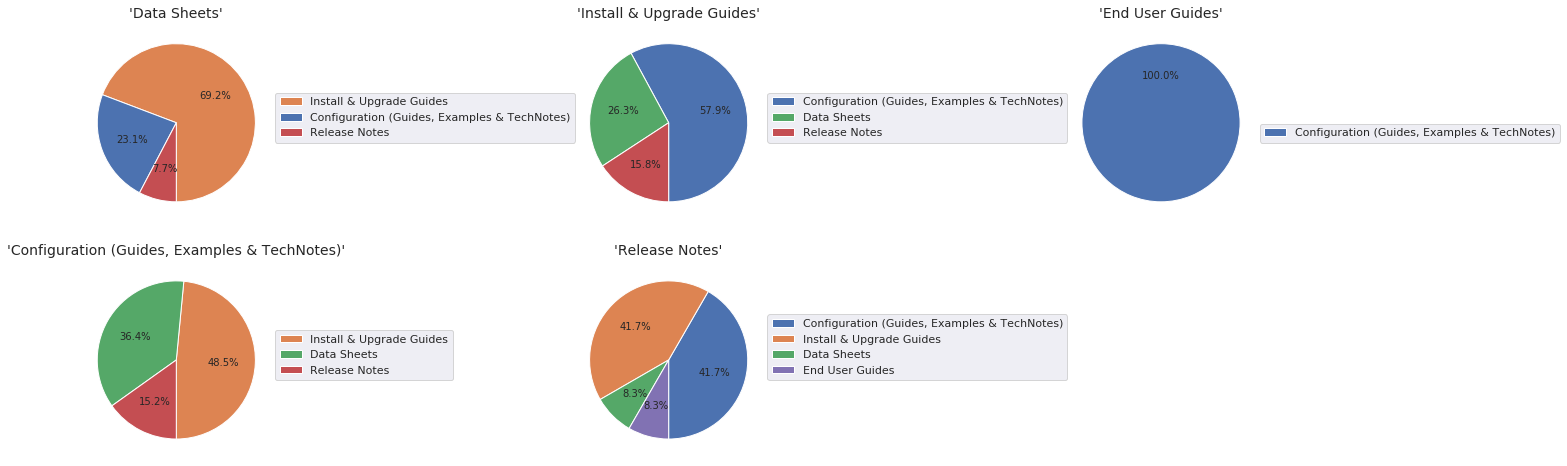

In [14]:
# For each misclassified class, analyze which class was predicted instead.
palette = dict(zip(df_bert_right_netbert_wrong['Class'].value_counts().index.tolist(), sns.color_palette()))
piechart_bad_preds(df_bert_right_netbert_wrong, palette)  

### 2.3. How does NetBERT improve BERT ?

- Goal: Consider only the queries that BERT misclassified, and run NetBERT on it. The purpose is to analyze how NetBERT improves the misclassifications of BERT.
- Analysis:
    * First, one can see a net improvement a net improvement for the 'End user guide', as Netbert classified correclty 78% of the queries of the same class that have been wrongly classified by BERT (notice however that only 9 queries were concerned).
    * Overall, NetBERt managed to classify correctly about 35-45% of the misclassified queries for each class.
    * Interesting to notice also that, in these misclassified queries, NetBERT classified the 'Data Sheets' queries as 'Install & Upgrade guides' even more than it classified the 'Install & Upgrade guides' themselves.

Accuracy: 0.353


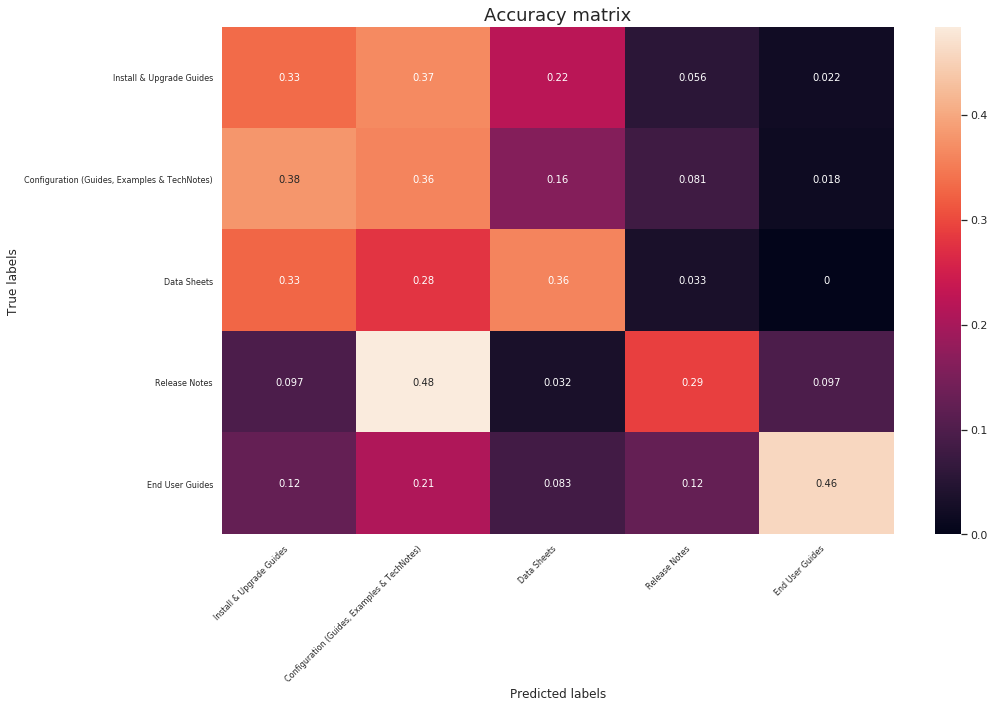

In [15]:
# Load scores.
result = load_results(dirpath=dirpath, filepath='scores_bert_wrong_preds.json')
print("Accuracy: {:.3f}".format(result['Accuracy']))

# Plot confusion matrix.
plot_confusion_matrix(result['conf_matrix'], list(class_mappings.values()))